In [22]:
# S1 ############################################################################################ 
# Generiranje kubičnih grafov, priprava in eksport podatkov za nadaljnje analize
# pripravi datoteki:
# Cn_cubic_graph_n10.sobj - generirani grafi
# Cn_all_cubic_graphs.csv - nekatere lastnoszi tgeneriranih grafov, ki jih rabimo za nadalnje analize
# 
# POMEMBNO: če grafi še niso generirani, postavi spremenljivko GENERIRAJ na True, če so grsfi že generirani in želiš
#           priprvait le datoteko csv z lastnostmi grafov, jo postsvi na False
#
from itertools import combinations 
import csv

n=16
GENERIRAJ = True

########################################
# 1) Interval-based indices
########################################

def interval_size(G, u, v):
    du = G.distances(source=u)
    dv = G.distances(source=v)
    d_uv = du[v]
    return sum(1 for w in G.vertices() if du[w] + dv[w] == d_uv)

def Int_index(G):
    dist = G.distance_all_pairs()   # dict-of-dicts
    V = G.vertices()
    s = 0
    for u, v in combinations(V, 2):
        d_uv = dist[u][v]
        # count vertices on some shortest u-v path
        cnt = sum(1 for w in V if dist[u][w] + dist[w][v] == d_uv)
        s += cnt - 1
    return s

def wiener_index(G):
    dist = G.distance_all_pairs()
    return sum(dist[u][v] for u, v in combinations(G.vertices(), 2))

########################################
# 2) Graph classification / properties
########################################

@parallel(8)
def graph_data(G, graph_id):
    IntG = Int_index(G)
    WG   = wiener_index(G)

    return {
        "id": graph_id,
        "n": G.order(),
        "m": G.size(),
        "planar": G.is_planar(),
        "bipartite": G.is_bipartite(),
        "bridgeless": (G.edge_connectivity() >= 2),
        "girth": G.girth(),
        "radius": G.radius(),
        "diameter": G.diameter(),
        "edge_connectivity": G.edge_connectivity(),
        "vertex_connectivity": G.vertex_connectivity(),
        "automorphism_group_order": G.automorphism_group().order(),
        "chromatic_index": G.chromatic_index(),
        "Int(G)": IntG,
        "Wiener(G)": WG,
        "Int(G)-Wiener(G)": IntG - WG
    }

########################################
# 3) Generate or read cubic graphs
########################################

if GENERIRAJ:
    print(f"Generiranje kubicnih gradov na {n} vozliscih....")
    all_cubic = list(graphs.nauty_geng(f"{n} -c -d3 -D3"))
    save(all_cubic, f"C{n}_cubic_graphs_n10.sobj")
    print(f"File savedC{n}_cubic_graphs_n10.sobj")
else:
    if 'all_cubic' not in globals():
        print(f"Nalaganje grafov iz datoteke C{n}_cubic_graphs_n10.sobj")
        all_cubic = load( f"C{n}_cubic_graphs_n10.sobj")

########################################
# 4) Write CSV
########################################

output_file = f"C{n}_cubic_graphs.csv"
print("Generiranje datoteke ",output_file)
with open(output_file, "w", newline="") as f:
    writer = None

    for i, G in enumerate(all_cubic):
        if i % 1000==0:
            print(f"prebranih {i}/{N}", flush=True)
        
        row = graph_data(G, i)

        if writer is None:
            # first row = column names
            writer = csv.DictWriter(f, fieldnames=row.keys())
            writer.writeheader()

        writer.writerow(row)

print(f"CSV written to {output_file}")

Generiranje kubicnih gradov na 16 vozliscih....
File savedC16_cubic_graphs_n10.sobj
Generiranje datoteke  C16_cubic_graphs.csv
prebranih 0/<function numerical_approx at 0x708e5fe09bc0>
prebranih 1000/<function numerical_approx at 0x708e5fe09bc0>
prebranih 2000/<function numerical_approx at 0x708e5fe09bc0>
prebranih 3000/<function numerical_approx at 0x708e5fe09bc0>
prebranih 4000/<function numerical_approx at 0x708e5fe09bc0>
CSV written to C16_cubic_graphs.csv


In [1]:
# S2 ###########################################
# Naložimo predhodno generirane podatke
#
#!python3 -m pip install pandas

import pandas as pd

#n=18

results = pd.read_csv(f"C{n}_cubic_graphs.csv")
if 'all_cubic' not in globals():
    all_cubic  = load(f"C{n}_cubic_graphs_n10.sobj")

print("Load complete, loaded graphs: ", len(results))

Load complete, loaded graphs:  41301


In [6]:
# definiramo Int(G)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# vzamemo hitrejšo - preveri še enkrat Marijno kodo

def interval_index(G):
    V = G.vertices()  # dobimo vsa vozlišča
    Int_G = 0
    
    # Iteriramo cez  vse pare vozlisc {u, v}
    for u in V:
        for v in V:
            # Izognemo se dvojnemu stetju (u,v) in (v,u) in (u,u)!
            if u >= v:
                continue
            d_uv = G.distance(u, v)    # poiscemo razdaljo
            
            interval_size = 0   # stevec za |I(u,v)|
            
            for w in V:
                d_uw = G.distance(u, w)
                d_wv = G.distance(w, v)
                
                if d_uw + d_wv == d_uv:
                    interval_size += 1
            
            Int_G += (interval_size - 1)
            
    return Int_G

print("Int(G) definirana!")

Int(G) definirana!


In [12]:
from itertools import combinations

def interval_index(G):
    dist = G.distance_all_pairs()   # dict-of-dicts
    V = G.vertices()
    s = 0
    for u, v in combinations(V, 2):
        d_uv = dist[u][v]
        # count vertices on some shortest u-v path
        cnt = sum(1 for w in V if dist[u][w] + dist[w][v] == d_uv)
        s += cnt - 1
    return s

print("Int(G) fast definirana!")

Int(G) fast definirana!


There are 41301 non isomorphic cubic graphs on 16 vertices.
Number of vertices: 16
Number of generated graphs: 41301
Int(PathGraph(16) = 680.


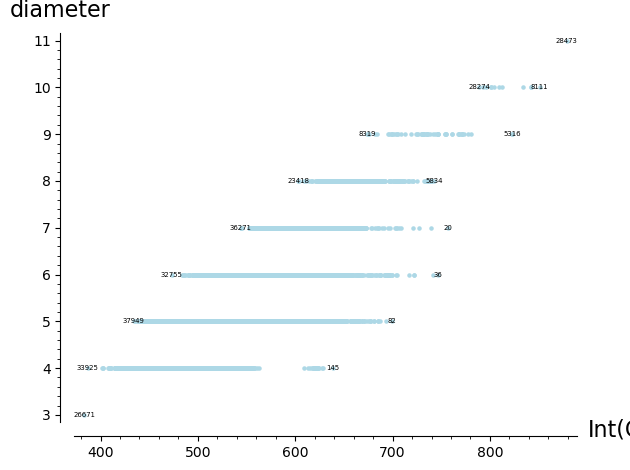

Vseh grafov na diagramu 41301, označenih 16.


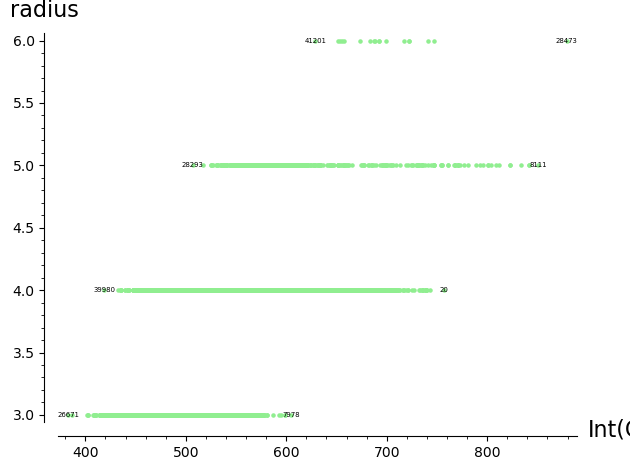

Vseh grafov na diagramu 41301, označenih 8.


In [23]:
# S3 ##########################################################
# narišemo sumarna grafa - v kolikor je treba, predhodno izvedi S1r
# 
import pandas as pd

#########################################
# results: DataFrame z Int(G) in diameter
x = results["Int(G)"]
y = results["diameter"]
num_graphs = len(results)

print(f"There are {num_graphs} non isomorphic cubic graphs on {n} vertices.")
print(f"Number of vertices: {n}")
print(f"Number of generated graphs: {num_graphs}")
vert = interval_index(graphs.PathGraph(n))
print(f"Int(PathGraph({n}) = {vert}.")

# ---- določi točke za označevanje ----

if num_graphs < 1000:
    # označi vse
    label_idx = results.index
else:
    label_idx = []

    # y so cela števila (diameter / radius)
    for y_val in sorted(results["diameter"].unique()):
        subset = results[results["diameter"] == y_val]
        if subset.empty:
            continue
        # min x za ta y
        idx_min = subset["Int(G)"].idxmin()
        # max x za ta y
        idx_max = subset["Int(G)"].idxmax()
        label_idx.append(idx_min)
        if idx_max != idx_min:
            label_idx.append(idx_max)

    label_idx = pd.Index(label_idx).unique()  # odstrani dvojnike

# ---- risanje v Sage ----

# vse točke brez napisov
Gpts = point(list(zip(x, y)), color='lightblue', size=5, faceted=True)

# napisi samo na izbranih indeksih
labels = Graphics()
for i in label_idx:
    xi = results.at[i, "Int(G)"]
    yi = results.at[i, "diameter"]
    labels += text(str(i+1), (xi, yi), color='black', fontsize=5)

p = Gpts + labels
p.axes_labels(['Int(G)', 'diameter'])
p.show()
print(f"Vseh grafov na diagramu {num_graphs}, označenih {len(label_idx)}.")

#######################################
# results: DataFrame z Int(G) in radij
y = results["radius"]

# ---- določi točke za označevanje ----

if num_graphs < 1000:
    # označi vse
    label_idx = results.index
else:
    label_idx = []

    # y so cela števila (diameter / radius)
    for y_val in sorted(results["radius"].unique()):
        subset = results[results["radius"] == y_val]
        if subset.empty:
            continue
        # min x za ta y
        idx_min = subset["Int(G)"].idxmin()
        # max x za ta y
        idx_max = subset["Int(G)"].idxmax()
        label_idx.append(idx_min)
        if idx_max != idx_min:
            label_idx.append(idx_max)

    label_idx = pd.Index(label_idx).unique()  # odstrani dvojnike

# ---- risanje v Sage ----

# vse točke brez napisov
Gpts = point(list(zip(x, y)), color='lightgreen', size=5, faceted=True)

# napisi samo na izbranih indeksih
labels = Graphics()
for i in label_idx:
    xi = results.at[i, "Int(G)"]
    yi = results.at[i, "radius"]
    labels += text(str(i+1), (xi, yi), color='black', fontsize=5)

p = Gpts + labels
p.axes_labels(['Int(G)', 'radius'])
p.show()
print(f"Vseh grafov na diagramu {num_graphs}, označenih {len(label_idx)}.")


18
int(G): 879   Premer: 11   Radij: 6   Bipartiten: False   Automorf.g.: 128


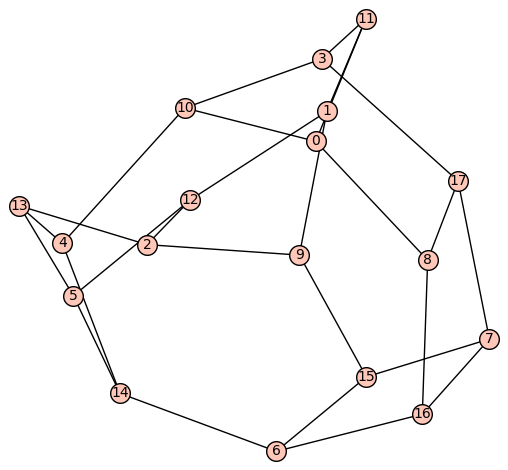

In [8]:
# S3 a ################################################
# izris posameznega grafa
print(n)
ind  = 1409
ind = ind-1
print("int(G):", results.at[i, "Int(G)"],"  Premer:", results.at[i, "diameter"],  "  Radij:", results.at[i, "radius"], "  Bipartiten:", results.at[i, "bipartite"], "  Automorf.g.:", results.at[i, "automorphism_group_order"])

#print("int(G) :",results.at[i,"Int(G)"], "  Radij: "results.at[i,"radius"])
all_cubic[ind].plot().show()


In [6]:
# S3 b #################################################
# Nariše in shrani grafe v graph_list v pdf datoteko out_pdf
#
def save_graphs_to_pdf(graph_list, out_pdf,
                       vertex_size=200,
                       base_height=3.2,
                       fig_width=8,
                       layout="circular",
                       fontsize=10):

    m = len(graph_list)

    if m == 0:
        print("Seznam grafov je prazen.")
        return

    if m > 60:
        print(f"Preveliko število grafov za risanje: {m} > 60")
        return

    rows = []
    for i, item in enumerate(graph_list):

        if isinstance(item, tuple):
            ie, g6 = item
            G = Graph(g6, format="graph6")
        else:
            ie = "?"
            G = item
        
        # izračuni lastnosti
        try:
            rad = G.radius()
        except Exception:
            rad = "?"
        try:
            diam = G.diameter()
        except Exception:
            diam = "?"
        try:
            bip = G.is_bipartite()
        except Exception:
            bip = "?"
        try:
            aut = G.automorphism_group().order()
        except Exception:
            aut = "?"

        # izris
        P = G.plot(
            graph_border=False,
            vertex_size=vertex_size,
            layout=layout
        )

        intg = interval_index(G)

        lbl = text(
            f"Ind: {i+1}  int(G): {intg} rad: {rad}   diam: {diam}   bip: {bip}   |Aut|: {aut}",
            (0, -0.35),
            fontsize=fontsize
        )

        rows.append(P + lbl)

    GA = graphics_array(rows, nrows=m, ncols=1)
    GA.save(out_pdf, axes=False, figsize=[fig_width, base_height * m])
    print(f"PDF datoteka '{out_pdf}' uspešno ustvarjena.")


In [24]:
# S4 #####################################################################################
# Statistična obdelava rezultatiov
# Leakage-free Random Forest analysis for Int(G) (Sage-friendly)
# - removes "Wiener(G)" and "Int(G)-Wiener(G)" from features by default
# - also supports predicting the residual Int(G)-Wiener(G) as a separate target

import os
# (recommended) limit native threading to avoid kernel crashes
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import csv
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


def load_xy_from_csv(
    filename,
    target_col="Int(G)",
    drop_cols=("id",),
    drop_feature_cols=(),
):
    """
    Load CSV -> (X, y, feature_names)

    - target_col: column to predict
    - drop_cols: columns never used (e.g. id)
    - drop_feature_cols: columns explicitly excluded from FEATURES (e.g. leakage)
    """
    with open(filename, newline="") as f:
        reader = csv.DictReader(f)
        cols = reader.fieldnames
        if cols is None:
            raise ValueError("CSV has no header row.")
        if target_col not in cols:
            raise KeyError(f"Target column '{target_col}' not found. Available: {cols}")

        drop_cols = set(drop_cols)
        drop_feature_cols = set(drop_feature_cols)

        feature_names = [
            c for c in cols
            if (c != target_col) and (c not in drop_cols) and (c not in drop_feature_cols)
        ]

        X_rows, y = [], []
        for row in reader:
            # target
            y.append(float(row[target_col]))

            # features
            feat = []
            for c in feature_names:
                val = row[c]
                if val in ("True", "False"):
                    feat.append(1.0 if val == "True" else 0.0)
                else:
                    # handle Sage "Infinity" if it ever appears
                    if val in ("+Infinity", "Infinity", "inf", "Inf"):
                        feat.append(float("inf"))
                    else:
                        feat.append(float(val))
            X_rows.append(feat)

    X = np.array(X_rows, dtype=float)
    y = np.array(y, dtype=float)

    # If any inf values exist, you must decide how to handle them.
    # For cubic connected graphs, girth/diameter/etc should be finite.
    if not np.isfinite(X).all():
        raise ValueError("Non-finite values (inf/nan) found in features. Clean your CSV or drop those columns.")

    return X, y, feature_names

@parallel(8)
def rf_analysis_no_leakage(
    csv_file,
    target_col="Int(G)",
    leakage_cols=("Wiener(G)", "Int(G)-Wiener(G)"),
    test_size=0.25,
    random_state=0,
    n_estimators=300,
    n_repeats=10,
):
    """
    Random Forest regression with leakage columns removed from features.

    Returns a dict with model + importances.
    """
    # Force sklearn-friendly base Python types (important in Sage)
    test_size_py = float(test_size) if test_size is not None else None
    rs_py = int(random_state) if random_state is not None else None

    X, y, feature_names = load_xy_from_csv(
        csv_file,
        target_col=target_col,
        drop_cols=("id",),
        drop_feature_cols=leakage_cols,   # <-- leakage removed here
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size_py, random_state=rs_py
    )

    # n_jobs=1 is safest in Sage/Jupyter
    rf = RandomForestRegressor(
        n_estimators=int(n_estimators),
        random_state=rs_py,
        n_jobs=1,
    )
    rf.fit(X_train, y_train)

    r2_train = rf.score(X_train, y_train)
    r2_test  = rf.score(X_test, y_test)

    # Permutation importance (most meaningful)
    perm = permutation_importance(
        rf, X_test, y_test,
        n_repeats=int(n_repeats),
        random_state=rs_py,
        n_jobs=1
    )
    perm_mean = perm.importances_mean
    perm_std  = perm.importances_std

    # Impurity-based importance (can be biased, still useful)
    imp = rf.feature_importances_

    print("=== Random Forest (LEAKAGE REMOVED) ===")
    print(f"File: {csv_file}")
    print(f"Target: {target_col}")
    print(f"Removed leakage cols from features: {list(leakage_cols)}")
    print(f"Samples: {len(y)} | Features used: {len(feature_names)}")
    print(f"R^2 train: {r2_train:.4f}")
    print(f"R^2 test : {r2_test:.4f}\n")

    order_imp = np.argsort(imp)[::-1]
    print("Top features (impurity importance):")
    for k in order_imp[:15]:
        print(f"  {feature_names[k]:30s}  {imp[k]:.6f}")

    order_perm = np.argsort(perm_mean)[::-1]
    print("\nTop features (permutation importance on test set):")
    for k in order_perm[:15]:
        print(f"  {feature_names[k]:30s}  {perm_mean[k]:.6f}  +/- {perm_std[k]:.6f}")

    return {
        "rf": rf,
        "feature_names": feature_names,
        "r2_train": r2_train,
        "r2_test": r2_test,
        "impurity_importance": imp,
        "perm_mean": perm_mean,
        "perm_std": perm_std,
    }


# -----------------------------
# ZAGON STATISTIKE
# -----------------------------

#n = 20
csv_file = f"C{n}_cubic_graphs.csv"

# A) Predict Int(G) using ONLY non-leakage properties
out_int = rf_analysis_no_leakage(
    csv_file,
    target_col="Int(G)",
    leakage_cols=("Wiener(G)", "Int(G)-Wiener(G)"),
    test_size=0.25,
    random_state=0,
    n_estimators=300,
    n_repeats=10
)

# B) (Recommended) Predict the "extra geodesic mass" Int(G)-Wiener(G)
#    using classical invariants (this is often more interesting scientifically)
out_extra = rf_analysis_no_leakage(
    csv_file,
    target_col="Int(G)-Wiener(G)",
    leakage_cols=("Int(G)", "Wiener(G)"),  # remove parts that trivially reconstruct the target
    test_size=0.25,
    random_state=0,
    n_estimators=300,
    n_repeats=10
)


=== Random Forest (LEAKAGE REMOVED) ===
File: C16_cubic_graphs.csv
Target: Int(G)
Removed leakage cols from features: ['Wiener(G)', 'Int(G)-Wiener(G)']
Samples: 4060 | Features used: 12
R^2 train: 0.7249
R^2 test : 0.6976

Top features (impurity importance):
  diameter                        0.627150
  radius                          0.231692
  bipartite                       0.059099
  automorphism_group_order        0.043254
  girth                           0.013230
  planar                          0.013186
  vertex_connectivity             0.004942
  edge_connectivity               0.004813
  chromatic_index                 0.001962
  bridgeless                      0.000673
  m                               0.000000
  n                               0.000000

Top features (permutation importance on test set):
  diameter                        0.837246  +/- 0.037104
  radius                          0.309777  +/- 0.014435
  bipartite                       0.074427  +/- 0.012256
  

=== Random Forest (LEAKAGE REMOVED) ===
File: C16_cubic_graphs.csv
Target: Int(G)-Wiener(G)
Removed leakage cols from features: ['Int(G)', 'Wiener(G)']
Samples: 4060 | Features used: 12
R^2 train: 0.4297
R^2 test : 0.3573

Top features (impurity importance):
  bipartite                       0.356858
  radius                          0.224282
  automorphism_group_order        0.138594
  diameter                        0.101642
  planar                          0.049016
  girth                           0.045203
  edge_connectivity               0.033757
  vertex_connectivity             0.032427
  chromatic_index                 0.011385
  bridgeless                      0.006837
  m                               0.000000
  n                               0.000000

Top features (permutation importance on test set):
  bipartite                       0.341055  +/- 0.014901
  radius                          0.301222  +/- 0.015609
  diameter                        0.225416  +/- 0.017732
  

In [11]:
# S5 - OPCIJSKO ####################################################################################
# Combined (multi-n) leakage-free analysis for Int(G) from CSVs:
#   files: C{n}_cubic_graphs.csv for even n in [nMin, nMax]
# Runs RandomForest with:
#   - leakage columns removed from FEATURES
#   - optional normalization of target to reduce size-dominance
#   - option to test on an unseen n (recommended)

import os
import multiprocessing as mp


# Prevent kernel crashes from OpenMP/BLAS oversubscription (set BEFORE numpy/sklearn import)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import csv
import math
import numpy as np
import sklearn

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# -----------------------------
# User settings
# -----------------------------
nMin = 16
nMax = 20

# Choose ONE target mode:
TARGET_COL = "Int(G)"          # raw target from CSV
NORMALIZE_TARGET = True        # if True: predict Int(G)/C(n,2) instead of Int(G)

# Leakage removal (for predicting Int(G) fairly)
LEAKAGE_COLS = ("Wiener(G)", "Int(G)-Wiener(G)")

# Split mode:
TEST_ON_UNSEEN_N = True        # recommended: hold out one n completely
HELD_OUT_N = nMax              # which n to hold out if TEST_ON_UNSEEN_N=True

# RF parameters (safe in notebooks)
N_ESTIMATORS = 300
N_REPEATS_PI = 10
RANDOM_STATE = 0


# -----------------------------
# Helpers
# -----------------------------
def choose2(n: int) -> int:
    return n * (n - 1) // 2

def file_for_n(n: int) -> str:
    return f"C{n}_cubic_graphs.csv"

def read_rows_with_n(filename: str, n_value: int):
    """Read CSV rows and add an explicit 'n_from_filename'."""
    with open(filename, newline="") as f:
        reader = csv.DictReader(f)
        if reader.fieldnames is None:
            raise ValueError(f"{filename}: missing header row")
        rows = []
        for r in reader:
            r["n_from_filename"] = str(n_value)
            rows.append(r)
        return reader.fieldnames + ["n_from_filename"], rows

def load_combined_data(nMin: int, nMax: int):
    """
    Loads all available C{n}_cubic_graphs.csv (even n).
    Returns (all_rows, all_columns).
    """
    all_rows = []
    all_cols = None

    for n in range(nMin, nMax + 1, 2):
        fn = file_for_n(n)
        if not os.path.exists(fn):
            print(f"[skip] missing file: {fn}")
            continue

        cols, rows = read_rows_with_n(fn, n)
        print(f"[load] {fn}: {len(rows)} rows")

        # Ensure consistent columns across files
        if all_cols is None:
            all_cols = cols
        else:
            # Require same base columns (order can differ; DictReader uses names)
            missing = set(all_cols) - set(cols)
            extra = set(cols) - set(all_cols)
            if missing or extra:
                raise ValueError(
                    f"Column mismatch in {fn}.\nMissing: {missing}\nExtra: {extra}"
                )

        all_rows.extend(rows)

    if all_cols is None:
        raise ValueError("No input files were found/loaded.")

    return all_rows, all_cols

def build_Xy(rows, target_col, leakage_cols, normalize_target=True):
    """
    Build X,y from dict rows:
      - target is Int(G) (raw) or Int(G)/C(n,2) if normalize_target
      - features exclude leakage cols and 'id' (position is index)
      - we include 'n_from_filename' as a feature (important for combined analysis)
    """
    drop_cols = {"id"}  # drop id if present
    leakage_cols = set(leakage_cols)

    # Determine available columns from first row
    cols = list(rows[0].keys())
    if target_col not in cols:
        raise KeyError(f"Target column '{target_col}' not found. Available: {cols}")

    # Feature set
    feature_names = []
    for c in cols:
        if c == target_col:
            continue
        if c in drop_cols:
            continue
        if c in leakage_cols:
            continue
        # Always keep n_from_filename
        feature_names.append(c)

    X = []
    y = []

    for r in rows:
        n_val = int(r["n_from_filename"])
        # target
        t = float(r[target_col])
        if normalize_target:
            t = t / float(choose2(n_val))
        y.append(t)

        # features
        feat = []
        for c in feature_names:
            v = r[c]
            if v in ("True", "False"):
                feat.append(1.0 if v == "True" else 0.0)
            else:
                if v in ("+Infinity", "Infinity", "inf", "Inf", "nan", "NaN", ""):
                    raise ValueError(f"Non-finite value in column '{c}': {v}")
                feat.append(float(v))
        X.append(feat)

    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)

    return X, y, feature_names

def print_top_importances(feature_names, values, std=None, topk=15, title=""):
    order = np.argsort(values)[::-1]
    if title:
        print(title)
    for k in order[:topk]:
        if std is None:
            print(f"  {feature_names[k]:30s} {values[k]:.6f}")
        else:
            print(f"  {feature_names[k]:30s} {values[k]:.6f} +/- {std[k]:.6f}")


# -----------------------------
# Main: load, split, train, report
# -----------------------------
rows, cols = load_combined_data(nMin, nMax)
X, y, feature_names = build_Xy(
    rows,
    target_col=TARGET_COL,
    leakage_cols=LEAKAGE_COLS,
    normalize_target=NORMALIZE_TARGET
)

# Choose split
rs = int(RANDOM_STATE)

if TEST_ON_UNSEEN_N:
    # Hold out all graphs with n_from_filename == HELD_OUT_N
    n_feat_idx = feature_names.index("n_from_filename")
    n_values = X[:, n_feat_idx].astype(int)

    test_mask = (n_values == int(HELD_OUT_N))
    train_mask = ~test_mask

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test   = X[test_mask],  y[test_mask]

    print(f"\n=== Split: train on n in [{nMin},{nMax}]\\{{{HELD_OUT_N}}}, test on n={HELD_OUT_N} ===")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=rs
    )
    print("\n=== Split: random 75/25 ===")

print(f"Samples total: {len(y)} | train: {len(y_train)} | test: {len(y_test)}")
print(f"Features used: {len(feature_names)}")
print(f"Target: {TARGET_COL} {'(normalized by C(n,2))' if NORMALIZE_TARGET else '(raw)'}")
print(f"Leakage removed from features: {list(LEAKAGE_COLS)}\n")

# Train RF (safe settings: n_jobs=1)
rf = RandomForestRegressor(
    n_estimators=int(N_ESTIMATORS),
    random_state=rs,
    n_jobs=1
)
rf.fit(X_train, y_train)

r2_train = rf.score(X_train, y_train)
r2_test  = rf.score(X_test, y_test)

print("=== Random Forest (combined n, leakage removed) ===")
print(f"R^2 train: {r2_train:.4f}")
print(f"R^2 test : {r2_test:.4f}\n")

# Importances
imp = rf.feature_importances_
print_top_importances(feature_names, imp, title="Top features (impurity importance):")

perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=int(N_REPEATS_PI),
    random_state=rs,
    n_jobs=1
)
print()
print_top_importances(feature_names, perm.importances_mean, perm.importances_std,
                      title="Top features (permutation importance on test set):")

# Optional: quick sanity check about the n feature
if "n_from_filename" in feature_names:
    i = feature_names.index("n_from_filename")
    print(f"\nPermutation importance of n_from_filename: {perm.importances_mean[i]:.6f} +/- {perm.importances_std[i]:.6f}")


[load] C16_cubic_graphs.csv: 4060 rows
[load] C18_cubic_graphs.csv: 41301 rows
[load] C20_cubic_graphs.csv: 510489 rows

=== Split: train on n in [16,20]\{20}, test on n=20 ===
Samples total: 555850 | train: 45361 | test: 510489
Features used: 13
Target: Int(G) (normalized by C(n,2))
Leakage removed from features: ['Wiener(G)', 'Int(G)-Wiener(G)']

=== Random Forest (combined n, leakage removed) ===
R^2 train: 0.7126
R^2 test : 0.5035

Top features (impurity importance):
  diameter                       0.685311
  radius                         0.215136
  bipartite                      0.047750
  automorphism_group_order       0.026640
  girth                          0.006114
  planar                         0.004333
  n                              0.003495
  m                              0.003485
  n_from_filename                0.003129
  vertex_connectivity            0.001483
  chromatic_index                0.001457
  edge_connectivity              0.001445
  bridgeless        

In [1]:
# S6 a ###################################################################
# Metaheuristika za kubične grafe (SageMath)
# EN ZAGON: MIN in MAX Int(G)
# IZVOZ: top 100 MIN in top 100 MAX v .g6 + CSV povzetek
#
# Nadgradnje:
#  - common random numbers (isti pari u,v v enem SA zagonu)
#  - adaptivno vzorčenje (hitro v SA, natančneje za topK)
#  - random baseline (npr. 10000 naključnih grafov) -> najboljši/slabši kot semena za SA
#  - CSV: dodani premer, W(G), Int-W, girth, mc info

import random, math, time, datetime, csv
import multiprocessing as mp

print("START:", datetime.datetime.now())

# ============================================================
# NASTAVITVE
# ============================================================
nmin = 40
nmax = 46

keep_connected = True

# SA parametri
steps = 30000
T0 = 1.0
alpha = 0.9992
neighbor_tries = 150

# Monte Carlo – osnova (hitro v SA)
mc_mult_fast = 6      # npr. 6*n parov v SA (hitro)
# Monte Carlo – izboljšanje top kandidatov (bolj stabilno)
mc_mult_refine = 24   # npr. 24*n parov za re-ranking topK

# topK iz vsakega SA zagona (nato združimo globalno)
keep_topK = 25

# multi-start SA (koliko SA zagonov na n)
restarts = 6
base_seed = 0

# naključni baseline (koliko naključnih grafov preden sploh zaženemo SA)
random_pool = 10000      # kot ste predlagali
# koliko najboljših/slabših iz random_pool uporabimo kot začetke za SA
seed_from_pool = 3       # top 3 za max in bottom 3 za min (skupaj 6)
# če je seed_from_pool > restarts, bo SA dobil več startov; sicer se odreže

# paralelizacija
try:
    n_jobs = max(1, mp.cpu_count() - 4)
except:
    n_jobs = 1

csv_out = f"Heuristic_{nmin}_{nmax}.csv"

# ============================================================
# 1) RAZDALJNA MATRICA + hitra Int (prek D)
# ============================================================
def dist_matrix(G):
    V = list(G.vertices())
    dd = G.distance_all_pairs()  # slovar slovarjev
    nV = len(V)
    D = [[0] * nV for _ in range(nV)]
    for i, u in enumerate(V):
        rowu = dd[u]
        for j, v in enumerate(V):
            D[i][j] = rowu[v]
    return D

def Int_from_D_on_pairs(D, pairs):
    """Oceni Int(G) z uporabo fiksnih parov (i,j) in razdaljne matrike D."""
    nV = len(D)
    total_pairs = nV * (nV - 1) // 2
    m = int(len(pairs))
    if m <= 0:
        return 0.0

    acc = 0.0
    for (i, j) in pairs:
        Dij = D[i][j]
        Di = D[i]
        cnt = -1
        # |I(u,v)| - 1 = # {w : d(i,w)+d(w,j)=d(i,j)} - 1
        for w in range(nV):
            if Di[w] + D[w][j] == Dij:
                cnt += 1
        acc += cnt

    return acc * (total_pairs / float(m))

def make_pair_sample(nV, m, rng):
    """Fiksni seznam parov (i,j), i<j, dolžine m."""
    pairs = []
    for _ in range(int(m)):
        i = rng.randrange(nV)
        j = rng.randrange(nV - 1)
        if j >= i:
            j += 1
        if i > j:
            i, j = j, i
        pairs.append((i, j))
    return pairs

def Int_exact_fast(G):
    D = dist_matrix(G)
    nV = len(D)
    s = 0
    for i in range(nV):
        Di = D[i]
        for j in range(i + 1, nV):
            Dij = Di[j]
            cnt = -1
            for w in range(nV):
                if Di[w] + D[w][j] == Dij:
                    cnt += 1
            s += cnt
    return int(s)

def Wiener_exact_fast(G):
    """Točen Wienerjev indeks z uporabo dist matrike."""
    D = dist_matrix(G)
    nV = len(D)
    w = 0
    for i in range(nV):
        for j in range(i + 1, nV):
            w += D[i][j]
    return int(w)

# ============================================================
# 2) 2-SWITCH SOSEDSTVO
# ============================================================
def two_switch_neighbor(G, max_tries, keep_connected=True):
    edges = list(G.edges(labels=False))
    Eset = set(tuple(sorted(e)) for e in edges)

    for _ in range(int(max_tries)):
        (a, b) = random.choice(edges)
        (c, d) = random.choice(edges)
        if len({a, b, c, d}) < 4:
            continue

        if random.random() < 0.5:
            e1, e2 = (a, c), (b, d)
        else:
            e1, e2 = (a, d), (b, c)

        e1 = tuple(sorted(e1))
        e2 = tuple(sorted(e2))

        if e1[0] == e1[1] or e2[0] == e2[1]:
            continue
        if e1 in Eset or e2 in Eset:
            continue

        G2 = G.copy()
        G2.delete_edge(a, b)
        G2.delete_edge(c, d)
        G2.add_edge(*e1)
        G2.add_edge(*e2)

        if keep_connected and not G2.is_connected():
            continue

        return G2, True

    return G, False

# ============================================================
# 3) SIMULATED ANNEALING (common random numbers + shrani topK)
# ============================================================
def sa_optimize(G0, maximize, keep_topK, pair_count, seed_local):
    """
    SA, kjer je ocena Int(G) MC na fiksnih parih (common random numbers).
    pair_count = koliko parov uporabljamo v SA fazi.
    """
    # lastni RNG, da je ponovljivo in ne mešamo globalnega random stanja
    rng = random.Random(int(seed_local))

    # fiksni pari za ta SA zagon
    nV = int(G0.order())
    pairs = make_pair_sample(nV, int(pair_count), rng)

    def score_fun(H):
        D = dist_matrix(H)
        return float(Int_from_D_on_pairs(D, pairs))

    G = G0.copy()
    cur = score_fun(G)

    top = []
    seen = set()

    def store(Gx, sx):
        g6 = Gx.graph6_string()
        if g6 in seen:
            return
        seen.add(g6)
        top.append((sx, g6))
        top.sort(key=lambda t: t[0], reverse=bool(maximize))
        if len(top) > int(keep_topK):
            for _, old in top[int(keep_topK):]:
                seen.discard(old)
            del top[int(keep_topK):]

    store(G, cur)
    T = float(T0)

    for _ in range(int(steps)):
        G2, ok = two_switch_neighbor(G, neighbor_tries, keep_connected)
        if not ok:
            T *= float(alpha)
            continue

        s2 = score_fun(G2)
        delta = (s2 - cur) if maximize else (cur - s2)

        if delta >= 0 or rng.random() < math.exp(delta / T):
            G, cur = G2, s2

        store(G, cur)
        T *= float(alpha)

    return top  # (mc_est, g6)

# ============================================================
# 4) NAKLJUČNI POVEZANI KUBIČNI GRAF
# ============================================================
def random_connected_cubic(n, rng):
    n = int(n)
    # graphs.RandomRegular uporablja Sage generator; za ponovljivost vsaj rng uporabimo za ponovitve
    G = graphs.RandomRegular(3, n)
    while not G.is_connected():
        G = graphs.RandomRegular(3, n)
    return G

# ============================================================
# 5) RANDOM BASELINE: izberi dobra semena za SA
# ============================================================
def baseline_seeds(n, pool_size, seed_local):
    """
    Generira pool_size naključnih povezanih kubičnih grafov,
    oceni Int(G) hitro (mc_mult_fast*n parov) in vrne
    top in bottom k grafov kot semena.
    """
    rng = random.Random(int(seed_local))
    n = int(n)
    k = int(seed_from_pool)

    # fiksni pari za baseline (da so primerjave poštene)
    pairs = make_pair_sample(n, int(mc_mult_fast) * n, rng)

    scored = []
    for _ in range(int(pool_size)):
        G = random_connected_cubic(n, rng)
        D = dist_matrix(G)
        s = float(Int_from_D_on_pairs(D, pairs))
        scored.append((s, G.graph6_string()))

    scored.sort(key=lambda t: t[0])
    lows = [g6 for _, g6 in scored[:k]]
    highs = [g6 for _, g6 in scored[-k:]]
    return highs, lows  # (za max), (za min)

# ============================================================
# 6) RE-RANK topK z več parov (refine) in nato točna vrednost
# ============================================================
def refine_and_exact(g6_list, n, maximize, seed_local):
    """
    Vzame g6 kandidate, jih ponovno oceni z več parov (mc_mult_refine*n),
    izbere najboljše po refined oceni in izračuna točen Int.
    """
    rng = random.Random(int(seed_local))
    n = int(n)

    # fiksni pari za refine (spet common random numbers za pošteno re-ranking)
    pairs_ref = make_pair_sample(n, int(mc_mult_refine) * n, rng)

    refined = []
    for g6 in g6_list:
        G = Graph(g6, format="graph6")
        D = dist_matrix(G)
        s = float(Int_from_D_on_pairs(D, pairs_ref))
        refined.append((s, g6))

    refined.sort(key=lambda t: t[0], reverse=bool(maximize))

    # točni Int za vse (lahko tudi samo za prvih npr. 200, če želite hitreje)
    exact = []
    for _, g6 in refined:
        G = Graph(g6, format="graph6")
        ie = Int_exact_fast(G)
        exact.append((g6, int(ie)))

    # vrni slovar g6->Int
    return exact

# ============================================================
# 7) WORKER: en restart → kandidati za MAX in MIN (SA + refine + exact)
# ============================================================
def one_restart_worker(args):
    n, r, start_g6_max, start_g6_min = args
    n = int(n)
    r = int(r)

    # seed mora biti Python int
    seed = int(int(base_seed) + r + n * 100000)

    # SA uporablja hitro MC
    pair_count_sa = int(mc_mult_fast) * n

    # MAX
    if start_g6_max is None:
        G0 = graphs.RandomRegular(3, n)
        while keep_connected and not G0.is_connected():
            G0 = graphs.RandomRegular(3, n)
    else:
        G0 = Graph(start_g6_max, format="graph6")

    top_max_mc = sa_optimize(G0, maximize=True, keep_topK=keep_topK,
                             pair_count=pair_count_sa, seed_local=seed + 111)

    # MIN
    if start_g6_min is None:
        G1 = graphs.RandomRegular(3, n)
        while keep_connected and not G1.is_connected():
            G1 = graphs.RandomRegular(3, n)
    else:
        G1 = Graph(start_g6_min, format="graph6")

    top_min_mc = sa_optimize(G1, maximize=False, keep_topK=keep_topK,
                             pair_count=pair_count_sa, seed_local=seed + 222)

    # refine + exact
    max_g6s = [g6 for _, g6 in top_max_mc]
    min_g6s = [g6 for _, g6 in top_min_mc]

    exact_max = refine_and_exact(max_g6s, n, maximize=True,  seed_local=seed + 333)
    exact_min = refine_and_exact(min_g6s, n, maximize=False, seed_local=seed + 444)

    return exact_max, exact_min

# ============================================================
# 8) MULTISTART + ZDRUŽEVANJE (z random baseline semeni)
# ============================================================
def multistart_minmax(n):
    n = int(n)

    # 1) random baseline -> semena
    highs, lows = baseline_seeds(n, pool_size=random_pool, seed_local=10_000_000 + n)

    # sestavi začetke za restarts (če je manj seedov, dopolni z None)
    start_max = list(highs)[:int(restarts)]
    start_min = list(lows)[:int(restarts)]

    while len(start_max) < int(restarts):
        start_max.append(None)
    while len(start_min) < int(restarts):
        start_min.append(None)

    args = [(n, int(r), start_max[r], start_min[r]) for r in range(int(restarts))]

    if int(n_jobs) == 1:
        out = list(map(one_restart_worker, args))
    else:
        with mp.Pool(int(n_jobs)) as pool:
            out = pool.map(one_restart_worker, args)

    # združi po točnih Int vrednostih
    max_dict, min_dict = {}, {}

    for max_list, min_list in out:
        for g6, ie in max_list:
            if g6 not in max_dict or ie > max_dict[g6]:
                max_dict[g6] = ie
        for g6, ie in min_list:
            if g6 not in min_dict or ie < min_dict[g6]:
                min_dict[g6] = ie

    max_sorted = sorted(max_dict.items(), key=lambda t: t[1], reverse=True)  # (g6, Int)
    min_sorted = sorted(min_dict.items(), key=lambda t: t[1])               # (g6, Int)

    return max_sorted, min_sorted

# ============================================================
# 9) GLAVNA ZANKA + IZVOZ
# ============================================================
rows = []
t0_all = time.time()

for n in range(int(nmin), int(nmax) + 1, 2):
    t0 = time.time()
    max_sorted, min_sorted = multistart_minmax(n)

    top_max_100 = max_sorted[:100]
    top_min_100 = min_sorted[:100]

    # globalna ekstrema
    max_g6, max_ie = top_max_100[0][0], int(top_max_100[0][1])
    min_g6, min_ie = top_min_100[0][0], int(top_min_100[0][1])

    Gmax = Graph(max_g6, format="graph6")
    Gmin = Graph(min_g6, format="graph6")

    # dodatne metrike (točno)
    Wmax = Wiener_exact_fast(Gmax)
    Wmin = Wiener_exact_fast(Gmin)

    rows.append({
        "n": int(n),

        "max_intG": int(max_ie),
        "max_W": int(Wmax),
        "max_Int_minus_W": int(max_ie - Wmax),
        "max_radius": int(Gmax.radius()),
        "max_diameter": int(Gmax.diameter()),
        "max_girth": int(Gmax.girth()),
        "max_bipartite": bool(Gmax.is_bipartite()),
        "max_automorphism": int(Gmax.automorphism_group().order()),

        "min_intG": int(min_ie),
        "min_W": int(Wmin),
        "min_Int_minus_W": int(min_ie - Wmin),
        "min_radius": int(Gmin.radius()),
        "min_diameter": int(Gmin.diameter()),
        "min_girth": int(Gmin.girth()),
        "min_bipartite": bool(Gmin.is_bipartite()),
        "min_automorphism": int(Gmin.automorphism_group().order()),

        "random_pool": int(random_pool),
        "restarts": int(restarts),
        "mc_mult_fast": int(mc_mult_fast),
        "mc_mult_refine": int(mc_mult_refine),
        "steps": int(steps)
    })

    # izvoz kandidatov
    with open(f"C{n}_max_100_n.g6", "w") as f:
        for g6, _ie in top_max_100:
            f.write(g6 + "\n")
    with open(f"C{n}_min_100_n.g6", "w") as f:
        for g6, _ie in top_min_100:
            f.write(g6 + "\n")

    print(
        f"n={n} | MAX Int={max_ie} | MIN Int={min_ie} | "
        f"time={time.time() - t0:.1f}s"
    )

with open(csv_out, "w", newline="") as f:
    writer = csv.DictWriter(
        f,
        fieldnames=[
            "n",
            "max_intG","max_W","max_Int_minus_W","max_radius","max_diameter","max_girth",
            "max_bipartite","max_automorphism",
            "min_intG","min_W","min_Int_minus_W","min_radius","min_diameter","min_girth",
            "min_bipartite","min_automorphism",
            "random_pool","restarts","mc_mult_fast","mc_mult_refine","steps"
        ]
    )
    writer.writeheader()
    writer.writerows(rows)

print("\nCSV exported:", csv_out)
print("DONE:", datetime.datetime.now(), " total_time=%.1fs" % (time.time() - t0_all))



START: 2025-12-17 06:55:42.639889
n=40 | MAX Int=8375 | MIN Int=3056 | time=218.1s
n=42 | MAX Int=11649 | MIN Int=3442 | time=244.4s
n=44 | MAX Int=11758 | MIN Int=3871 | time=297.4s
n=46 | MAX Int=12990 | MIN Int=4241 | time=307.0s

CSV exported: Heuristic_40_46.csv
DONE: 2025-12-17 07:13:29.664836  total_time=1067.0s


In [6]:
# S6 ###################################################################
# Metaheuristika za kubične grafe
# EN ZAGON: MIN in MAX Int(G)
# IZVOZ: top 100 MIN in top 100 MAX v .g6 + CSV povzetek

import random, math, time, datetime, csv
import multiprocessing as mp

print("START:", datetime.datetime.now())

# ============================================================
# NASTAVITVE
# ============================================================
nmin = 46
nmax = 46

keep_connected = True

# SA parametri
steps = 30000
T0 = 1.0
alpha = 0.9992
neighbor_tries = 150

# Monte Carlo (8*n .. 12*n)
mc_mult = 12

# topK iz vsakega SA zagona (nato združimo globalno)
keep_topK = 25

# multi-start
restarts = 6
base_seed = 0

# paralelizacija
try:
    n_jobs = max(1, mp.cpu_count() - 4)
except:
    n_jobs = 1

csv_out = f"Heuristic_{nmin}_{nmax}_{mc_mult}.csv"

# ============================================================
# 1) RAZDALJNA MATRICA + Int
# ============================================================
def dist_matrix(G):
    V = list(G.vertices())
    dd = G.distance_all_pairs()
    nV = len(V)
    D = [[0] * nV for _ in range(nV)]
    for i, u in enumerate(V):
        rowu = dd[u]
        for j, v in enumerate(V):
            D[i][j] = rowu[v]
    return D

def Int_sampled_fast(G, samples):
    D = dist_matrix(G)
    nV = len(D)
    total_pairs = nV * (nV - 1) // 2

    acc = 0.0
    rr = random.randrange
    for _ in range(int(samples)):
        i = rr(nV)
        j = rr(nV - 1)
        if j >= i:
            j += 1
        Dij = D[i][j]
        Di = D[i]
        cnt = -1
        for w in range(nV):
            if Di[w] + D[w][j] == Dij:
                cnt += 1
        acc += cnt

    return acc * (total_pairs / float(samples))

def Int_exact_fast(G):
    D = dist_matrix(G)
    nV = len(D)
    s = 0
    for i in range(nV):
        Di = D[i]
        for j in range(i + 1, nV):
            Dij = Di[j]
            cnt = -1
            for w in range(nV):
                if Di[w] + D[w][j] == Dij:
                    cnt += 1
            s += cnt
    return s

# ============================================================
# 2) 2-SWITCH SOSEDSTVO
# ============================================================
def two_switch_neighbor(G, max_tries, keep_connected=True):
    edges = list(G.edges(labels=False))
    Eset = set(tuple(sorted(e)) for e in edges)

    for _ in range(int(max_tries)):
        (a, b) = random.choice(edges)
        (c, d) = random.choice(edges)
        if len({a, b, c, d}) < 4:
            continue

        if random.random() < 0.5:
            e1, e2 = (a, c), (b, d)
        else:
            e1, e2 = (a, d), (b, c)

        e1 = tuple(sorted(e1))
        e2 = tuple(sorted(e2))

        if e1[0] == e1[1] or e2[0] == e2[1]:
            continue
        if e1 in Eset or e2 in Eset:
            continue

        G2 = G.copy()
        G2.delete_edge(a, b)
        G2.delete_edge(c, d)
        G2.add_edge(*e1)
        G2.add_edge(*e2)

        if keep_connected and not G2.is_connected():
            continue

        return G2, True

    return G, False

# ============================================================
# 3) SIMULATED ANNEALING (shrani topK)
# ============================================================
def sa_optimize(G0, score_fun, maximize, keep_topK):
    G = G0.copy()
    cur = score_fun(G)

    top = []
    seen = set()

    def store(Gx, sx):
        g6 = Gx.graph6_string()
        if g6 in seen:
            return
        seen.add(g6)
        top.append((sx, g6))
        top.sort(key=lambda t: t[0], reverse=maximize)
        if len(top) > int(keep_topK):
            for _, old in top[int(keep_topK):]:
                seen.discard(old)
            del top[int(keep_topK):]

    store(G, cur)
    T = float(T0)

    for _ in range(int(steps)):
        G2, ok = two_switch_neighbor(G, neighbor_tries, keep_connected)
        if not ok:
            T *= float(alpha)
            continue

        s2 = score_fun(G2)
        delta = (s2 - cur) if maximize else (cur - s2)

        if delta >= 0 or random.random() < math.exp(delta / T):
            G, cur = G2, s2

        store(G, cur)
        T *= float(alpha)

    return top

# ============================================================
# 4) NAKLJUČNI POVEZANI KUBIČNI GRAF
# ============================================================
def random_connected_cubic(n):
    n = int(n)
    G = graphs.RandomRegular(3, n)
    while not G.is_connected():
        G = graphs.RandomRegular(3, n)
    return G

# ============================================================
# 5) WORKER: en restart → kandidati za MAX in MIN
# ============================================================
def one_restart_worker(args):
    n, r = args
    n = int(n)
    r = int(r)

    # Always produce a Python int seed at the very end.
    seed = int(int(base_seed) + r + n * 100000)
    random.seed(seed)

    mc_samples = int(mc_mult) * n
    score_fun = lambda H: Int_sampled_fast(H, mc_samples)

    # MAX
    G0 = random_connected_cubic(n)
    top_max = sa_optimize(G0, score_fun, True, keep_topK)
    exact_max = [(Int_exact_fast(Graph(g6, format="graph6")), g6) for _, g6 in top_max]

    # MIN (DO NOT use Integer(...); ensure int again)
    seed2 = int(seed + 777777)
    random.seed(seed2)

    G1 = random_connected_cubic(n)
    top_min = sa_optimize(G1, score_fun, False, keep_topK)
    exact_min = [(Int_exact_fast(Graph(g6, format="graph6")), g6) for _, g6 in top_min]

    return exact_max, exact_min

# ============================================================
# 6) MULTISTART + ZDRUŽEVANJE
# ============================================================
def multistart_minmax(n):
    n = int(n)
    args = [(n, int(r)) for r in range(int(restarts))]

    if int(n_jobs) == 1:
        out = map(one_restart_worker, args)
    else:
        with mp.Pool(int(n_jobs)) as pool:
            out = pool.map(one_restart_worker, args)

    max_dict, min_dict = {}, {}

    for max_list, min_list in out:
        for ie, g6 in max_list:
            if g6 not in max_dict or ie > max_dict[g6]:
                max_dict[g6] = ie
        for ie, g6 in min_list:
            if g6 not in min_dict or ie < min_dict[g6]:
                min_dict[g6] = ie

    max_sorted = sorted(max_dict.items(), key=lambda t: t[1], reverse=True)
    min_sorted = sorted(min_dict.items(), key=lambda t: t[1])

    return max_sorted, min_sorted

# ============================================================
# 7) GLAVNA ZANKA + IZVOZ
# ============================================================
rows = []
t0_all = time.time()

# Pure Python range + slicing (no Integer anywhere)
for n in range(int(nmin), int(nmax) + 1, 2):
    t0 = time.time()
    max_sorted, min_sorted = multistart_minmax(n)

    top_max_100 = max_sorted[:100]
    top_min_100 = min_sorted[:100]

    # globalna ekstrema
    max_g6, max_ie = top_max_100[0][0], top_max_100[0][1]
    min_g6, min_ie = top_min_100[0][0], top_min_100[0][1]

    Gmax = Graph(max_g6, format="graph6")
    Gmin = Graph(min_g6, format="graph6")

    rows.append({
        "n": int(n),
        "max_intG": max_ie,
        "max_radius": Gmax.radius(),
        "max_bipartite": Gmax.is_bipartite(),
        "max_automorphism": Gmax.automorphism_group().order(),
        "min_intG": min_ie,
        "min_radius": Gmin.radius(),
        "min_bipartite": Gmin.is_bipartite(),
        "min_automorphism": Gmin.automorphism_group().order()
    })

    with open(f"C{n}_max_100_{mc_mult}.g6", "w") as f:
        for g6, _ie in top_max_100:
            f.write(g6 + "\n")
    with open(f"C{n}_min_100_{mc_mult}.g6", "w") as f:
        for g6, _ie in top_min_100:
            f.write(g6 + "\n")

    print(
        f"n={n} | "
        f"MAX Int={max_ie} | "
        f"MIN Int={min_ie} | "
        f"time={time.time() - t0:.1f}s"
    )

with open(csv_out, "w", newline="") as f:
    writer = csv.DictWriter(
        f,
        fieldnames=[
            "n",
            "max_intG", "max_radius", "max_bipartite", "max_automorphism",
            "min_intG", "min_radius", "min_bipartite", "min_automorphism"
        ]
    )
    writer.writeheader()
    writer.writerows(rows)

print("\nCSV exported:", csv_out)
print("DONE:", datetime.datetime.now(), " total_time=%.1fs" % (time.time() - t0_all))


START: 2025-12-17 08:25:47.588861
n=46 | MAX Int=12721 | MIN Int=4394 | time=581.5s

CSV exported: Heuristic_46_46_12.csv
DONE: 2025-12-17 08:35:29.055178  total_time=581.5s


In [10]:
# ============================================================
# S7: Vzorčenje kubičnih grafov + shranjevanje vzorca + "pipeta" CSV
# Ubuntu + Sage: multiprocesiranje na max(cpu-4)
# ============================================================

import random
from math import comb
from itertools import combinations
from multiprocessing import cpu_count, get_context
import csv
import os

# Sage objects (v Sage so na voljo)
# Graph, graphs


# ----------------------------
# Generate random connected cubic graphs
# ----------------------------
def random_connected_cubic(n, max_tries=10000):
    n = int(n)
    if n % 2 == 1:
        raise ValueError("Za kubične (3-regularne) grafe mora biti n sodo.")
    for _ in range(int(max_tries)):
        G = graphs.RandomRegular(3, n)
        if G.is_connected():
            return G
    raise RuntimeError("Ni uspelo generirati povezanega kubičnega grafa (preveč poskusov).")


# ----------------------------
# All-pairs distances (Sage-version-safe)
# ----------------------------
def _all_pairs_dist_dict(G):
    """
    Vrne dist kot dict-of-dicts: dist[u][v] = razdalja.
    Preferira distance_all_pairs(); če je ni, fallback na BFS iz vsakega vozlišča.
    """
    try:
        dist = G.distance_all_pairs()
        _ = next(iter(dist.values()))
        return dist
    except Exception:
        dist = {}
        for u in G.vertices():
            dist[u] = G.shortest_path_lengths(u)
        return dist


# ----------------------------
# Int(G) exact
# ----------------------------
def Int_exact(G):
    V = list(G.vertices())
    n = len(V)
    if n < 2:
        return 0.0

    dist = _all_pairs_dist_dict(G)
    s = 0
    for u, v in combinations(V, 2):
        d_uv = dist[u][v]
        du, dv = dist[u], dist[v]
        cnt = 0
        for w in V:
            if du[w] + dv[w] == d_uv:
                cnt += 1
        s += (cnt - 1)
    return float(s)


# ----------------------------
# Fast sampled Int(G)
# ----------------------------
def Int_sampled_fast(G, samples=400, rng=None):
    V = list(G.vertices())
    n = len(V)
    if n < 2:
        return 0.0

    samples = int(samples)
    dist = _all_pairs_dist_dict(G)
    total_pairs = comb(n, 2)

    # exact if samples >= all pairs
    if samples >= total_pairs:
        return Int_exact(G)

    if rng is None:
        rng = random.Random()

    acc = 0.0
    for _ in range(samples):
        u, v = rng.sample(V, 2)
        d_uv = dist[u][v]
        du, dv = dist[u], dist[v]
        cnt = 0
        for w in V:
            if du[w] + dv[w] == d_uv:
                cnt += 1
        acc += (cnt - 1)

    return (acc / float(samples)) * float(total_pairs)


# ----------------------------
# Worker: naredi 1 graf + vrni (i, int_hat, g6)
# ----------------------------
def _one_job(args):
    i, n, int_samples, base_seed, max_tries = args
    i = int(i); n = int(n); int_samples = int(int_samples)
    base_seed = int(base_seed); max_tries = int(max_tries)

    # determinističen seed po jobu
    job_seed = int((base_seed * 1_000_003 + i * 97_531) & 0xFFFFFFFF)
    rng = random.Random(job_seed)

    G = random_connected_cubic(n, max_tries=max_tries)
    int_hat = Int_sampled_fast(G, samples=int_samples, rng=rng)

    g6 = G.graph6_string()
    return (i, float(int_hat), g6)


# ----------------------------
# Main: za dano n, m najdi max/min, shrani vzorec, izvozi "pipeta" CSV
# ----------------------------
def sample_and_export_like_pipette(
    n, m,
    seed=42,
    int_samples=300,
    reserve_cpus=4,
    chunksize=50,
    progress_every=5000,
    max_tries=10000,
    out_dir="."
):
    n = int(n); m = int(m); seed = int(seed)
    int_samples = int(int_samples)
    reserve_cpus = int(reserve_cpus)
    chunksize = int(chunksize)
    progress_every = int(progress_every)
    max_tries = int(max_tries)

    os.makedirs(out_dir, exist_ok=True)

    procs = max(1, cpu_count() - reserve_cpus)
    print(f"[n={n}] Using {procs} processes (cpu_count={cpu_count()}, reserve={reserve_cpus}).")

    jobs = [(i, n, int_samples, seed, max_tries) for i in range(m)]

    # datoteke za shranjevanje vzorca
    sample_csv_path = os.path.join(out_dir, f"Sample_{n}-{m}_sample.csv")
    sample_g6_path  = os.path.join(out_dir, f"Sample_{n}-{m}_sample.g6")

    # sprotno sledenje ekstremov (po int_hat)
    max_rec = None  # (i, int_hat, g6)
    min_rec = None

    ctx = get_context("fork")  # Ubuntu + Sage

    done = 0
    with open(sample_csv_path, "w", newline="") as fcsv, open(sample_g6_path, "w") as fg6:
        w = csv.DictWriter(fcsv, fieldnames=["i", "int_hat", "g6"])
        w.writeheader()

        with ctx.Pool(processes=procs) as pool:
            for rec in pool.imap_unordered(_one_job, jobs, chunksize=chunksize):
                done += 1
                i, int_hat, g6 = rec

                # shrani vzorec
                w.writerow({"i": i, "int_hat": float(int_hat), "g6": g6})
                fg6.write(g6.strip() + "\n")

                # posodobi max/min (po oceni)
                if (max_rec is None) or (int_hat > max_rec[1]):
                    max_rec = rec
                if (min_rec is None) or (int_hat < min_rec[1]):
                    min_rec = rec

                if progress_every and (done % progress_every == 0):
                    print(f"[n={n}] Done {done}/{m}")

    print(f"[n={n}] Wrote sample CSV: {sample_csv_path}")
    print(f"[n={n}] Wrote sample g6 : {sample_g6_path}")

    # rekonstruiraj max/min graf
    Gmax = Graph(max_rec[2], format="graph6")
    Gmin = Graph(min_rec[2], format="graph6")

    # izračun "pipeta" vrednosti na max/min grafu
    # (Int(G) izračunam točno za poročilo)
    max_int_exact = Int_exact(Gmax)
    min_int_exact = Int_exact(Gmin)

    row = {
        "n": n,

        "max_intG": float(max_int_exact),
        "max_radius": int(Gmax.radius()),
        "max_bipartite": bool(Gmax.is_bipartite()),
        "max_automorphism": int(Gmax.automorphism_group().order()),

        "min_intG": float(min_int_exact),
        "min_radius": int(Gmin.radius()),
        "min_bipartite": bool(Gmin.is_bipartite()),
        "min_automorphism": int(Gmin.automorphism_group().order()),
    }

    # shrani še max/min grafa kot .g6 (za reproducibilnost)
    max_g6_path = os.path.join(out_dir, f"Sample_{n}-{m}_MAX.g6")
    min_g6_path = os.path.join(out_dir, f"Sample_{n}-{m}_MIN.g6")
    with open(max_g6_path, "w") as f:
        f.write(Gmax.graph6_string().strip() + "\n")
    with open(min_g6_path, "w") as f:
        f.write(Gmin.graph6_string().strip() + "\n")
    print(f"[n={n}] Wrote MAX graph6: {max_g6_path}")
    print(f"[n={n}] Wrote MIN graph6: {min_g6_path}")

    # pipeta CSV (enaka glava kot v tvoji pripeti datoteki)
    pipeta_path = os.path.join(out_dir, f"Sample_{n}-{m}.csv")
    fieldnames = [
        "n",
        "max_intG", "max_radius", "max_bipartite", "max_automorphism",
        "min_intG", "min_radius", "min_bipartite", "min_automorphism"
    ]
    with open(pipeta_path, "w", newline="") as f:
        wp = csv.DictWriter(f, fieldnames=fieldnames)
        wp.writeheader()
        wp.writerow(row)

    print(f"[n={n}] Wrote pipeta CSV: {pipeta_path}")
    return row, pipeta_path, sample_csv_path, sample_g6_path, max_g6_path, min_g6_path


# ----------------------------
# Example run
# ----------------------------
if __name__ == "__main__":
    n = 46
    m = 500000
    int_samples = 500

    row, pipeta_path, sample_csv_path, sample_g6_path, max_g6_path, min_g6_path = sample_and_export_like_pipette(
        n=n, m=m,
        seed=42,
        int_samples=int_samples,
        reserve_cpus=4,
        chunksize=50,
        progress_every=5000,
        max_tries=10000,
        out_dir="."
    )

    print("Row written:")
    print(row)


[n=46] Using 8 processes (cpu_count=12, reserve=4).
[n=46] Done 5000/500000
[n=46] Done 10000/500000
[n=46] Done 15000/500000
[n=46] Done 20000/500000
[n=46] Done 25000/500000
[n=46] Done 30000/500000
[n=46] Done 35000/500000
[n=46] Done 40000/500000
[n=46] Done 45000/500000
[n=46] Done 50000/500000
[n=46] Done 55000/500000
[n=46] Done 60000/500000
[n=46] Done 65000/500000
[n=46] Done 70000/500000
[n=46] Done 75000/500000
[n=46] Done 80000/500000
[n=46] Done 85000/500000
[n=46] Done 90000/500000
[n=46] Done 95000/500000
[n=46] Done 100000/500000
[n=46] Done 105000/500000
[n=46] Done 110000/500000
[n=46] Done 115000/500000
[n=46] Done 120000/500000
[n=46] Done 125000/500000
[n=46] Done 130000/500000
[n=46] Done 135000/500000
[n=46] Done 140000/500000
[n=46] Done 145000/500000
[n=46] Done 150000/500000
[n=46] Done 155000/500000
[n=46] Done 160000/500000
[n=46] Done 165000/500000
[n=46] Done 170000/500000
[n=46] Done 175000/500000
[n=46] Done 180000/500000
[n=46] Done 185000/500000
[n=46]